# **Cross-data analysis**

---------------------------

**Motivation:**

Azoospermia is a condition where men do not produce any spermatozoa or produce semen of too low quality for allowing pregnancy to actually happen. Various types of azoospermia can happen, and those will look differently at a cellular level, as you can see below.

![](https://raw.githubusercontent.com/hds-sandbox/scRNASeq_course/main/docs/python/img/azoospermia.png)
*Examples of testicular histology and the composition of testicular cell types that can be observed among men with non-obstructive azoospermia. a A biopsy from a patient with Klinefelter syndrome (47, XXY) showing degenerated ghost tubules (#), tubules with Sertoli-cell-only (SCO) pattern (*) and large clusters of Leydig cells. b SCO (*) observed in a patient with a complete AZFc deletion. c Tubules with germ cell neoplasia in situ, GCNIS, which do not contain any normal germ cells (&). GCNIS cells are the precursor cells of testicular germ cell cancer and are found more frequently among men with azoospermia than among men with good semen quality (Hoei-Hansen et al. 2003). d Classical Sertoli-cell-only syndrome (SCOS) where no germ cells are present. Only Sertoli cells are found inside the seminiferous tubules marked with an asterisk (*). e SCO (*) with partial hyalinisation of tubules (#). f Spermatocytic arrest (SPA) (§) at the stage of spermatocytes. The bar represents 100 microns and all images are in the same magnification. From (Soraggi et al 2020)*.

Common to the various azoospermic conditions is the lack or distuption of gene expression patterns. It makes therefore sense to detect genes expressed more in the healthy dataset against the azoospermic one. We can also investigate gene enrichment databases to get a clearer picture of what the genes of interest are relevant to.

We try to do a simple analysis of the dataset with "healthy" cells against a dataset with azoospermic cells: we integrate the data, apply differential expression and gene enrichment analysis. The azoospermic dataset has been already preprocessed and clustered. Notebooks for the whole process to elaborate the data are included under the section `Extra` of the course webpage, and can be found in the folder `Notebooks/Python/Azoospermia`. The original data is also provided, so you can as well play around on your own to preprocess and cluster again the data.

---------------------------

**Learning objectives:**

- Integrate datasets and detect DE genes in two different health conditions
- Evaluate visually the integration results
- Perform and interpret gene enrichment analysis

----------------
**Execution time: 30 minutes**

---------------

***Import packages***

In [1]:
import scanpy as sc
import pandas as pd
import scvelo as scv
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import anndata as ad
import gseapy as gp

plt.rcParams['figure.figsize']=(6,6) #rescale figures

In [2]:
import rpy2.robjects as ro

import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

In [3]:
%%R
.libPaths( c( "../../../../sandbox_scRNA_testAndFeedback/scrna-environment/lib/R/library/" ) )

Read the data for healthy and azoospermic patient

In [4]:
healthy = sc.read('../../Data/notebooks_data/sample_123.filt.norm.red.clst.2.times.h5ad')
azoospermic = sc.read('../../../../sandbox_scRNA_testAndFeedback/scRNASeq_course/Data/notebooks_data/crypto_123.filt.norm.red.clst.2.times.h5ad') 

Only considering the two last: ['.times', '.h5ad'].
Only considering the two last: ['.times', '.h5ad'].
Only considering the two last: ['.times', '.h5ad'].
Only considering the two last: ['.times', '.h5ad'].


Rename cluster variable to match the two datasets

In [5]:
azoospermic.obs['clusters_som']=azoospermic.obs['clusters_spc'].copy()

Just a reminder of available clusters and UMAP plot. In this case we have matching clusters apart from SpermatogoniaB - whose markers were not observed in azoospermic patients. Note also differences in pseudotimes.

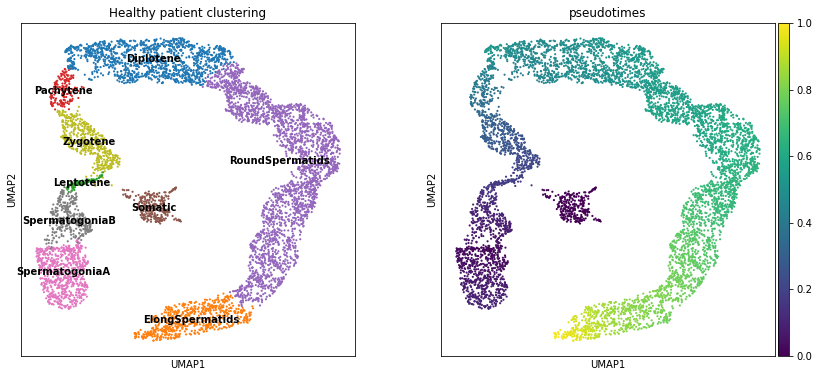

In [6]:
sc.pl.umap(healthy, color=['clusters_spc','pseudotimes'], 
           legend_loc='on data', title='Healthy patient clustering')

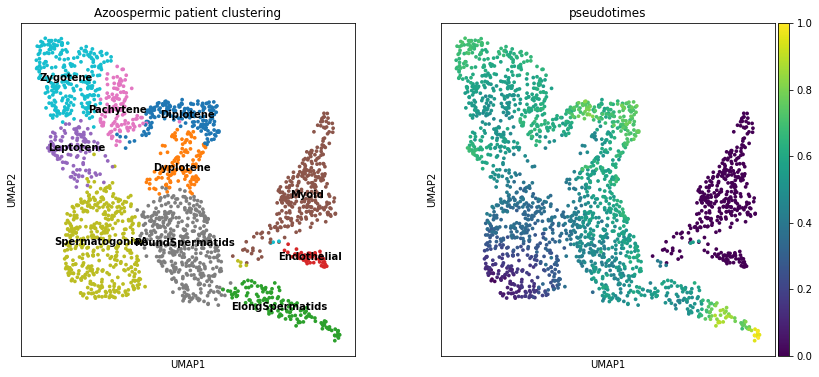

In [7]:
sc.pl.umap(azoospermic, color=['clusters_spc','pseudotimes'], 
           legend_loc='on data', title='Azoospermic patient clustering')

In [8]:
healthy.shape

(6431, 22790)

In [9]:
azoospermic.shape

(2147, 14018)

## Put data together

One possible comparison is to do a differential gene expression of each cluster found in both datasets. In this way we can find genes expressed in one sample and not the other. To do this we first concatenate the datasets and normalize them.

In [10]:
batch_names = ['healthy','azoospermic'] #choose names for samples
sample = ad.AnnData.concatenate(healthy, azoospermic, batch_key='condition') #concatenate
sample.rename_categories(key='condition', categories=batch_names) #apply sample names
scv.utils.cleanup(sample, clean='var') #remove duplicated gene quantites

We normalize the data and consider both batch and condition as batch variable to distinguish samples

In [11]:
sample.obs['batch_condition'] = [f'{i}_{j}' for i,j in zip(sample.obs['batch'],sample.obs['condition'])]

In [12]:
rawMatrix = np.array( sample.layers['umi_raw'].T.copy())
genes_name = sample.var_names
cells_info = sample.obs[ ["batch_condition"] ].copy()

In [13]:
%%R -i cells_info -i rawMatrix -i genes_name
library(scater)
cell_df <- DataFrame(data = cells_info)
colnames(rawMatrix) <- rownames(cell_df) #cell names
rownames(rawMatrix) <- genes_name #gene names

In [14]:
%%R
library(sctransform)
library(future)
future::plan(strategy = 'multicore', workers = 32)
options(future.globals.maxSize = 50 * 1024 ^ 3)

In [15]:
%%R
vst_out=vst( as.matrix(rawMatrix), #data matrix
            cell_attr=cell_df, #dataframe containing batch variable
            n_genes=3000, #most variable genes in your data
            batch_var='data.batch_condition', #name of the batch variable
            method='qpoisson', #type of statistical model. use "poisson" for more precision but much slower execution
            show_progress=TRUE, #show progress bars
            return_corrected_umi=TRUE) #return corrected umi count matrix

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


In [16]:
%%R -o new_matrix -o sct_genes -o all_genes -o umi_matrix
new_matrix=vst_out$y #normalized matrix
sct_genes = rownames(vst_out$model_pars) #most variable genes
all_genes = rownames(new_matrix) #vector of all genes to check if any have been filtered out
umi_matrix=vst_out$umi_corrected #umi matrix

In [17]:
sct_genes = list(sct_genes)
sample.var['highly_variable'] = [i in sct_genes for i in sample.var_names]

In [18]:
sample = sample[:,list(all_genes)].copy()

In [19]:
sample.layers['norm_sct_condition'] = np.transpose( new_matrix )
sample.layers['umi_sct_condition'] = np.transpose( umi_matrix )

Now we have less genes because of the azoospermic dataset

In [20]:
sample

AnnData object with n_obs × n_vars = 8578 × 14009
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'perc_mito', 'n_counts', 'n_genes', 'doublet_score', 'predicted_doublet', 'batch', 'leiden', 'clusters', 'clusters_spc', 'pseudotimes', 'clusters_som', 'condition', 'batch_condition'
    var: 'highly_variable'
    obsm: 'X_pca', 'X_umap'
    layers: 'norm_sct', 'umi_log', 'umi_raw', 'umi_sct', 'umi_tpm', 'norm_sct_condition', 'umi_sct_condition'

## Differential expression

Here we do a simple differential expression analysis of all healthy vs all azoospermic cells. We can see how healhy samples mostly dominate with the expression of genes related to the development of sperm, especially in the round and elongated spermatids stages. many of the genes for azoospermic cells are ribosomal genes.

In [21]:
sample.X = sample.layers['umi_sct_condition'].copy()
sc.pp.log1p(sample)

In [22]:
sc.tl.rank_genes_groups(sample, groupby='condition', key_added='DE_condition', 
                        use_raw=False, n_genes=50, method='wilcoxon')

... storing 'batch' as categorical
... storing 'leiden' as categorical
... storing 'clusters' as categorical
... storing 'clusters_spc' as categorical
... storing 'batch_condition' as categorical


In [23]:
pd.DataFrame(sample.uns['DE_condition']['names'])

,healthy,azoospermic
0,PRM2,RPS27
1,PRM1,RPS29
2,CRISP2,RPS26
3,TNP1,RANBP1
4,CCDC7,FTH1
5,TRIM36,RPS23
6,ZNF295-AS1,RPL34
7,LINC01921,RPL38
8,ODF2,RPS28
9,MLF1,RPL37


You can again look at log-fold changes and p-values

In [24]:
result = sample.uns['DE_condition']
groups = result['names'].dtype.names
X = pd.DataFrame(
    {group + '_' + key[:1].upper(): result[key][group]
    for group in groups for key in ['names', 'pvals_adj','logfoldchanges']})
X

,healthy_N,healthy_P,healthy_L,azoospermic_N,azoospermic_P,azoospermic_L
0,PRM2,0.000000e+00,2.032233,RPS27,0.000000e+00,1.026861
1,PRM1,8.437521e-278,2.002583,RPS29,0.000000e+00,1.019021
2,CRISP2,1.365587e-275,2.028542,RPS26,5.887639e-283,1.706868
3,TNP1,3.314488e-248,1.960973,RANBP1,2.006989e-258,1.354506
4,CCDC7,3.481192e-218,1.627345,FTH1,7.402147e-247,1.787864
5,TRIM36,9.660027e-212,1.600318,RPS23,1.312549e-243,1.120837
6,ZNF295-AS1,8.585883e-207,2.665506,RPL34,4.200615e-230,0.888604
7,LINC01921,4.328831e-204,2.113969,RPL38,3.827195e-223,0.688914
8,ODF2,1.599192e-201,1.300002,RPS28,1.337696e-220,1.546971
9,MLF1,1.570552e-200,1.216649,RPL37,1.047240e-218,0.832729


In [25]:
X.to_csv('../../Data/results/diff_expression_condition.csv', header=True, index=False)

Integration plot. We use the standard PCA because it is faster and rely on `bbknn` for correcting differences between samples. While we could not identify Somatic cells in healthy data, now they can be distinguished into endothelial and somatic with the overlapping UMAP plot

In [26]:
sample.X = sample.layers['norm_sct_condition'].copy() #use normalized data in .X
sc.pp.scale(sample) #standardize
sc.preprocessing.pca(sample, svd_solver='arpack', random_state=12345) #do PCA

In [27]:
import bbknn as bbknn
bbknn.bbknn(sample, batch_key='batch_condition')

In [28]:
sc.tools.umap(sample, random_state=54321)

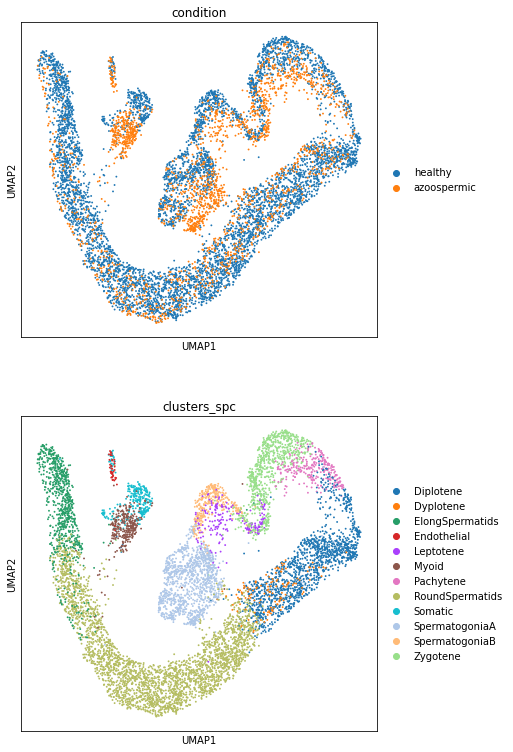

In [29]:
sc.plotting.umap(sample, color=['condition','clusters_spc'], ncols=1)

Below, we average the UMAP coordinates for each cluster in the azoospermic (A) and healthy (H) dataset, and plot those averages. We can see if they are close to each other, or if they are far apart. Notice that  `Spermatogonia B` and `Leptotene` overlap. This because in only one of the two dataset we have left some spermatogonia B cells where we could not observe leptotene markers. But we could also have misedentified some Spermatogonia A cells. Somatic cells are off compared to the myoid and endothelial, simply because of the different cell identification

[Text(0.5, 0, 'UMAP_0'), Text(0, 0.5, 'UMAP_1')]

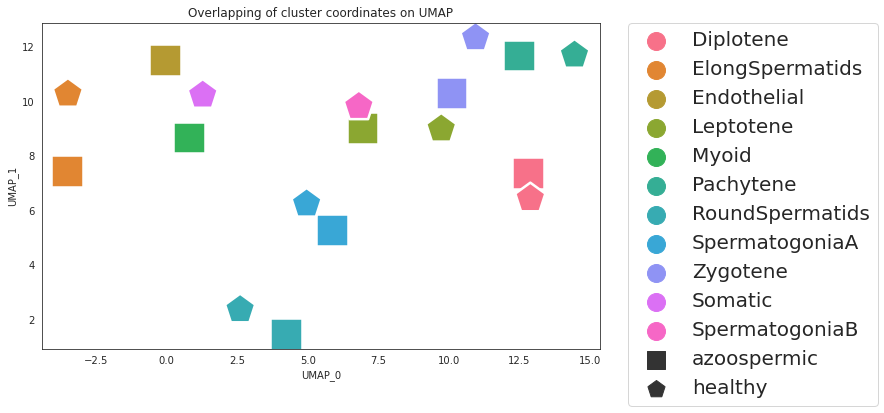

In [30]:
new_names = np.array([ str(i[0]).upper() + '_' + str(j) for i,j in 
             zip(sample.obs['condition'], sample.obs['clusters_spc']) ])

np.unique(new_names)

markers = { 'azoospermic':'s', 'healthy':'p' }

idx = [i=='A_Dyplotene' for i in new_names]
new_names[idx]  = 'A_Diplotene'

np.unique(new_names)

plt.rcParams['figure.figsize']=(10,6) #rescale figures
X_umap = sample.obsm['X_umap'].copy()
x = []
y = []
clst = []
condition = []

#need the same category names order to have the same color palette for the clusters
for i in np.unique(new_names):
    boolean = [j==i for j in new_names]
    x.append( np.mean(X_umap[boolean,0]) )
    y.append( np.mean(X_umap[boolean,1]) )
    clst.append( i.split('_')[1] )
    condition.append( sample.obs['condition'][boolean][0] )
sns.set_style("white", {'axes.grid' : False})    
g=sns.scatterplot(x,y,style=condition,hue=clst, markers=markers, s=1000)
g.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize= 20, markerscale = 3)
g.set_title('Overlapping of cluster coordinates on UMAP')
g.set(xlabel = 'UMAP_0', ylabel='UMAP_1')  


We can look at the percentage of cell clusters in the two datasets. This is not a much reliable number for usage when clustering by hand looking at markers, because we might misidentify some subclusters into one type or the other. For example Spermatogonia B and Leptotene in the healthy data sum up to the amount of leptotene cells in the azoospermic data

In [33]:
healthy.obs['clusters_spc'].value_counts() / healthy.shape[0] * 100

RoundSpermatids    39.200746
Diplotene          19.406002
SpermatogoniaA     10.620432
ElongSpermatids     9.609703
Zygotene            7.510496
SpermatogoniaB      5.100295
Somatic             4.587156
Pachytene           2.612346
Leptotene           1.352822
Name: clusters_spc, dtype: float64

In [34]:
azoospermic.obs['clusters_spc'].value_counts() / azoospermic.shape[0] * 100

SpermatogoniaA     19.701910
RoundSpermatids    19.329297
Myoid              14.019562
Zygotene           12.529110
Diplotene           8.337215
ElongSpermatids     6.380997
Dyplotene           6.054960
Leptotene           5.728924
Pachytene           5.635771
Endothelial         2.282254
Name: clusters_spc, dtype: float64

In [35]:
sample.write('../../Data/notebooks_data/condition.integrated.h5ad')

## Gene enrichment

Let's do enrichment analysis to see how differentially expressed genes from healthy patients can be interpreted. We use the package `gseapy`, that allows you to choose a lot of gene enrichment archives to explore. This package is just an interface to the website [Enrichr](https://maayanlab.cloud/Enrichr/), where you can copy-paste a list of genes and visualize the same results as in this `python` code.

In [36]:
sample = sc.read('../../Data/notebooks_data/condition.integrated.h5ad')

load differential expression table

In [37]:
DE_genes = pd.read_csv('../../Data/results/diff_expression_condition.csv')
DE_genes = DE_genes.loc[:, [i.split('_')[1]=='N' for i in DE_genes.columns] ]

Run gene enrichment analysis. Results are in the folders `Data/results/enrichment_condition/healthy` and `Data/results/enrichment_condition/azoospermic` of the course material. 

In [38]:
enrich_results = dict()
for CONDITION in DE_genes.columns:
    print('------Enrichment analysis for condition ' + CONDITION.split('_')[0] + '------')
    enrich_results[CONDITION.split('_')[0]] = gp.enrichr(gene_list=DE_genes[CONDITION],
                 gene_sets=[ 'ARCHS4_TFs_Coexp',
                             'Chromosome_Location_hg19',
                             'WikiPathway_2021_Human',
                             'ARCHS4_Tissues',
                             'GO_Molecular_Function_2021',],
                 organism='Human', # don't forget to set organism to the one you desired
                 description=CONDITION,
                 outdir=f'../../Data/results/enrichment_condition/{CONDITION}',                              
                 cutoff=0.05 # p-value for enrichment test.
                )

------Enrichment analysis for condition healthy------


2022-02-23 12:46:10,635 Warning: No enrich terms using library Chromosome_Location_hg19 when cutoff = 0.05
2022-02-23 12:46:18,540 Warning: No enrich terms using library GO_Molecular_Function_2021 when cutoff = 0.05


------Enrichment analysis for condition azoospermic------


2022-02-23 12:46:24,940 Warning: No enrich terms using library Chromosome_Location_hg19 when cutoff = 0.05


Note we have chosen five databases as example (option `gene_sets`), but you can see a list with all databases below, or by visiting the webpage

In [39]:
gp.get_library_name()

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_10x_scRNA_2021',
 'Allen_Brain_Atlas_down',
 'Allen_Brain_Atlas_up',
 'Azimuth_Cell_Types_2021',
 'BioCarta_2013',
 'BioCarta_2015',
 'BioCarta_2016',
 'BioPlanet_2019',
 'BioPlex_2017',
 'CCLE_Proteomics_2020',
 'CORUM',
 'COVID-19_Related_Gene_Sets',
 'COVID-19_Related_Gene_Sets_2021',
 'Cancer_Cell_Line_Encyclopedia',
 'CellMarker_Augmented_2021',
 'ChEA_2013',
 'ChEA_2015',
 'ChEA_2016',
 'Chromosome_Location',
 'Chromosome_Location_hg19',
 'ClinVar_2019',
 'DSigDB',
 'Data_Acquisition_Method_Most_Popular_Genes',
 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019',
 'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019',
 'Descartes_Cell_Types_and_Tissue_2021',
 'DisGeNET',
 'Disease_Perturbations_from_GEO_down',
 'Disease_Perturbati

We can plot some information here instead of looking into folders. we can plot a table with pvalues, genes present in the database and their enrichment term. Here the enrichment for healthy samples (filtered with pvalue <0.01)

In [40]:
healthy_table = enrich_results['healthy'].results #get the table

In [41]:
healthy_table.head() #table preview

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,ARCHS4_TFs_Coexp,YBX2 human tf ARCHS4 coexpression,16/299,1.298141e-17,3.810044e-15,0,0,32.703388,1271.606272,ROPN1B;SMCP;CRISP2;PRM2;CCDC110;PRM1;ODF2;DKKL...
1,ARCHS4_TFs_Coexp,HSF5 human tf ARCHS4 coexpression,16/299,1.298141e-17,3.810044e-15,0,0,32.703388,1271.606272,ROPN1B;SMCP;CRISP2;PRM2;PRM1;ODF2;HMGB4;CABYR;...
2,ARCHS4_TFs_Coexp,DHX57 human tf ARCHS4 coexpression,13/299,3.105686e-13,6.076792e-11,0,0,24.157248,695.737723,SMCP;CRISP2;PRM2;PRM1;ODF2;HMGB4;CABYR;CAPZA3;...
3,ARCHS4_TFs_Coexp,SOX30 human tf ARCHS4 coexpression,12/299,7.312013e-12,4.292151e-10,0,0,21.635430,554.764935,SMCP;CRISP2;PRM2;PRM1;CABYR;CAPZA3;ODF2;ADAD1;...
4,ARCHS4_TFs_Coexp,CUL3 human tf ARCHS4 coexpression,12/299,7.312013e-12,4.292151e-10,0,0,21.635430,554.764935,SMCP;CRISP2;PRM2;PRM1;CABYR;CAPZA3;ODF2;CCDC7;...


Note the `Wikipathway` results at the end of the table, where we have genes related to male infertility (when their expression is disrupted) and genes involved in the Cori Cycle (essential for spermatogenesis). Also, Sperm and Testis are recognized as likely tissues from which our data comes from. Relevant transcriptio factors highlighted here are for example HSF5 (early spermatogenesis), YBX2 (Abnormal spermatogenesis in case of disruption), SOX30 (male fertility). Using gene enrichment analyses requires of course a biological background to understand the usefulness of results.

In [42]:
healthy_table[ healthy_table['Adjusted P-value']<0.01 ] #filtered with pvalue

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,ARCHS4_TFs_Coexp,YBX2 human tf ARCHS4 coexpression,16/299,1.298141e-17,3.810044e-15,0,0,32.703388,1271.606272,ROPN1B;SMCP;CRISP2;PRM2;CCDC110;PRM1;ODF2;DKKL...
1,ARCHS4_TFs_Coexp,HSF5 human tf ARCHS4 coexpression,16/299,1.298141e-17,3.810044e-15,0,0,32.703388,1271.606272,ROPN1B;SMCP;CRISP2;PRM2;PRM1;ODF2;HMGB4;CABYR;...
2,ARCHS4_TFs_Coexp,DHX57 human tf ARCHS4 coexpression,13/299,3.105686e-13,6.076792e-11,0,0,24.157248,695.737723,SMCP;CRISP2;PRM2;PRM1;ODF2;HMGB4;CABYR;CAPZA3;...
3,ARCHS4_TFs_Coexp,SOX30 human tf ARCHS4 coexpression,12/299,7.312013e-12,4.292151e-10,0,0,21.635430,554.764935,SMCP;CRISP2;PRM2;PRM1;CABYR;CAPZA3;ODF2;ADAD1;...
4,ARCHS4_TFs_Coexp,CUL3 human tf ARCHS4 coexpression,12/299,7.312013e-12,4.292151e-10,0,0,21.635430,554.764935,SMCP;CRISP2;PRM2;PRM1;CABYR;CAPZA3;ODF2;CCDC7;...
5,ARCHS4_TFs_Coexp,ZDHHC19 human tf ARCHS4 coexpression,12/299,7.312013e-12,4.292151e-10,0,0,21.635430,554.764935,SMCP;CRISP2;PRM2;PRM1;CABYR;CAPZA3;ODF2;CCDC7;...
6,ARCHS4_TFs_Coexp,HIST1H1T human tf ARCHS4 coexpression,12/299,7.312013e-12,4.292151e-10,0,0,21.635430,554.764935,ROPN1B;PRM2;CCDC110;PRM1;CABYR;ODF2;GSG1;ADAD1...
7,ARCHS4_TFs_Coexp,RFX4 human tf ARCHS4 coexpression,12/299,7.312013e-12,4.292151e-10,0,0,21.635430,554.764935,SMCP;CRISP2;PRM2;PRM1;CABYR;CAPZA3;TRIM36;PGK2...
8,ARCHS4_TFs_Coexp,ZNF541 human tf ARCHS4 coexpression,12/299,7.312013e-12,4.292151e-10,0,0,21.635430,554.764935,SMCP;CRISP2;PRM2;PRM1;CABYR;CAPZA3;ODF2;ADAD1;...
9,ARCHS4_TFs_Coexp,DMRTC2 human tf ARCHS4 coexpression,12/299,7.312013e-12,4.292151e-10,0,0,21.635430,554.764935,SMCP;CRISP2;PRM2;PRM1;CABYR;CAPZA3;ODF2;CCDC7;...


In the azoospermic patient most of the enrichment terms are related to ribosomal genes and therefore to processes such as rRNA binding. There isn't much information to get out of this table

In [43]:
azoos_table = enrich_results['azoospermic'].results

In [44]:
azoos_table.head() #table preview

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,ARCHS4_TFs_Coexp,EIF3K human tf ARCHS4 coexpression,25/299,7.600257e-33,4.377748e-30,0,0,71.810219,5310.877416,RPL10;RPL12;RPL34;RPLP1;RPLP0;RPL36A;RPL10A;UB...
1,ARCHS4_TFs_Coexp,RFXANK human tf ARCHS4 coexpression,21/299,1.044332e-25,3.007676e-23,0,0,51.241875,2947.496732,PRELID1;RPS9;RPL41;RPL10;RPS8;RPL34;RPLP1;RPLP...
2,ARCHS4_TFs_Coexp,FOXB1 human tf ARCHS4 coexpression,18/299,9.769366e-21,1.875718e-18,0,0,39.372998,1814.112285,RPL41;RPL21;RPL34;RPLP1;RPLP0;RPL36A;RPL6;UBL5...
3,ARCHS4_TFs_Coexp,POU3F1 human tf ARCHS4 coexpression,17/299,3.725729e-19,5.365050e-17,0,0,35.929078,1524.609259,RPL41;RPL21;RPL34;RPLP1;RPL36A;RPL6;UBL5;RPS14...
4,ARCHS4_TFs_Coexp,SOX2 human tf ARCHS4 coexpression,16/299,1.298141e-17,1.495459e-15,0,0,32.703388,1271.606272,RPL41;RPL21;RPL34;RPLP1;RPL36A;RPL6;UBL5;RPS14...


In [45]:
azoos_table[ azoos_table['Adjusted P-value']<0.01 ]

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,ARCHS4_TFs_Coexp,EIF3K human tf ARCHS4 coexpression,25/299,7.600257e-33,4.377748e-30,0,0,71.810219,5310.877416,RPL10;RPL12;RPL34;RPLP1;RPLP0;RPL36A;RPL10A;UB...
1,ARCHS4_TFs_Coexp,RFXANK human tf ARCHS4 coexpression,21/299,1.044332e-25,3.007676e-23,0,0,51.241875,2947.496732,PRELID1;RPS9;RPL41;RPL10;RPS8;RPL34;RPLP1;RPLP...
2,ARCHS4_TFs_Coexp,FOXB1 human tf ARCHS4 coexpression,18/299,9.769366e-21,1.875718e-18,0,0,39.372998,1814.112285,RPL41;RPL21;RPL34;RPLP1;RPLP0;RPL36A;RPL6;UBL5...
3,ARCHS4_TFs_Coexp,POU3F1 human tf ARCHS4 coexpression,17/299,3.725729e-19,5.365050e-17,0,0,35.929078,1524.609259,RPL41;RPL21;RPL34;RPLP1;RPL36A;RPL6;UBL5;RPS14...
4,ARCHS4_TFs_Coexp,SOX2 human tf ARCHS4 coexpression,16/299,1.298141e-17,1.495459e-15,0,0,32.703388,1271.606272,RPL41;RPL21;RPL34;RPLP1;RPL36A;RPL6;UBL5;RPS14...
...,...,...,...,...,...,...,...,...,...,...
656,GO_Molecular_Function_2021,rRNA binding (GO:0019843),6/42,8.766374e-10,3.199726e-08,0,0,75.431818,1573.125115,RPS14;RPS9;RPL12;RPLP0;RPS3;NOP53
657,GO_Molecular_Function_2021,mRNA binding (GO:0003729),7/263,3.869450e-06,9.415662e-05,0,0,12.523438,156.072065,SRRM2;RPS26;RPS14;RPL41;PCBP2;RPS3;RPS2
658,GO_Molecular_Function_2021,large ribosomal subunit rRNA binding (GO:0070180),2/5,6.095679e-05,1.112461e-03,0,0,277.041667,2688.785055,RPL12;RPLP0
659,GO_Molecular_Function_2021,cadherin binding (GO:0045296),6/322,1.454970e-04,2.124256e-03,0,0,8.472670,74.859047,RPS26;RANBP1;RPL34;RPL14;RPS2;RPL6


## Wrapping up

We have performed a basic analysis of one dataset against the other, and seen how we can find a lot of relevant information about how azoospermic patients are characterized in terms of absence of specific genes and enrichment terms. Note that gene enrichment can be applied in any type of analysis, and this application is just a specific showcase.